In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, auc

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cv_splits_csv/train.csv', header=0, delimiter=",")
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cv_splits_csv/val.csv', header=0, delimiter=",")
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cv_splits_csv/test.csv', header=0, delimiter=",")

In [6]:
print("Training data: ", train_data.shape)
print("Validation data: ", val_data.shape)
print("Test data: ", test_data.shape)

Training data:  (17870, 3)
Validation data:  (5957, 3)
Test data:  (5956, 3)


In [ ]:
train_data.head(5)

,Id,Text,Tags
0,6589,"Operations Manager Operations <span class=""hl""...",['Software_Developer']
1,15618,"Network Administratoir <span class=""hl"">Networ...",['Network_Administrator']
2,6751,"IT Delivery Manager <span class=""hl"">IT</span>...",['Project_manager']
3,29164,"Web Developer <span class=""hl"">Web</span> <spa...","['Web_Developer', 'Software_Developer']"
4,3288,Self-Employed Self-Employed Self-Employed - Se...,"['Web_Developer', 'Software_Developer', 'Front..."


In [ ]:
train_texts, train_labels = train_data['Text'], train_data['Tags']
validation_texts, validation_labels = val_data['Text'], val_data['Tags']
test_texts, test_labels = test_data['Text'], test_data['Tags']

#### Encoding labels of train, validation, and test set
**Converting** string of list to list using *literal_eval* function. </br>
Using MultiLabelBinarizer to encode the multiclass multilabel target

In [ ]:
train_labels = [literal_eval(labels) for labels in train_labels]
validation_labels = [literal_eval(labels) for labels in validation_labels]
test_labels = [literal_eval(labels) for labels in test_labels]

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_labels)

MultiLabelBinarizer()

In [ ]:
print (multilabel_binarizer.classes_)

['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']


In [ ]:
train_labels_binarized = multilabel_binarizer.transform(train_labels)
validation_labels_binarized = multilabel_binarizer.transform(validation_labels)
test_labels_binarized = multilabel_binarizer.transform(test_labels)

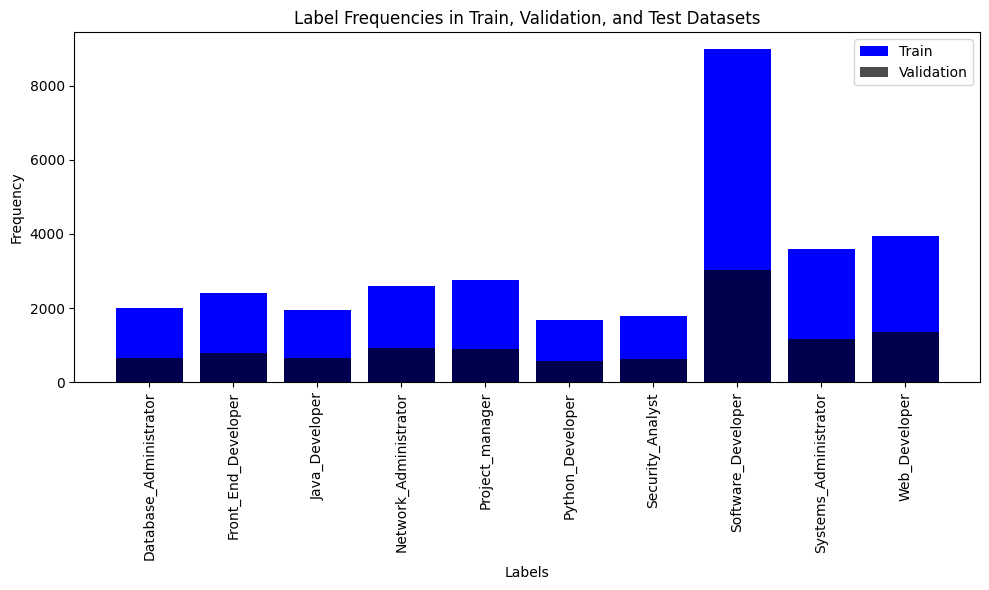

In [ ]:
# Calculate label frequencies in train, validation, and test datasets
train_label_freq = [sum(label) for label in train_labels_binarized.T]
val_label_freq = [sum(label) for label in validation_labels_binarized.T]
test_label_freq = [sum(label) for label in test_labels_binarized.T]

label_names = multilabel_binarizer.classes_

# Plot bar charts
plt.figure(figsize=(10, 6))
plt.bar(label_names, train_label_freq, color='blue', label='Train')
plt.bar(label_names, val_label_freq, color='black', label='Validation', alpha=0.7)
#plt.bar(label_names, test_label_freq, color='red', label='Test', alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Frequencies in Train, Validation, and Test Datasets')
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
results = {
    'BoW': {
        'Logistic Regression': None,
        'SVM': None,
        'Random Forest': None
    },
    'Tf-Idf': {
        'Logistic Regression': None,
        'SVM': None,
        'Random Forest': None
    },
    'Word2Vec': {
        'Logistic Regression': None,
        'SVM': None,
        'Random Forest': None
    }
}

### Pre-processing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()

def preprocess_resume_text(text):
    # Remove HTML tags and special characters using regular expressions
    cleaned_text = re.sub(r'<[^>]+>', ' ', text)
    cleaned_text = re.sub(r'[^\w.+/#-]', ' ', cleaned_text)

    # Convert to lowercase
    cleaned_text = cleaned_text.lower()

    #Tokenize text into words
    words = word_tokenize(cleaned_text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    # Join words back into a single string
    preprocessed_text = ' '.join(filtered_words)

    return preprocessed_text

In [ ]:
train_prep = train_texts.apply(preprocess_resume_text)
val_prep = validation_texts.apply(preprocess_resume_text)
test_prep = test_texts.apply(preprocess_resume_text)

### Bag of Words

In [ ]:
# Initialize the CountVectorizer with tuned parameters
vectorizer = CountVectorizer(
    max_features=1000,  # Limit the vocabulary size to the top 1000 words
    min_df=2,           # Ignore words that appear in fewer than 2 documents
    max_df=0.8,         # Ignore words that appear in more than 80% of documents
    ngram_range=(1, 3),    # Consider both single words and pairs of words
    token_pattern=r'\b\w+\b'  # Define tokens as consecutive word characters
)

# Fit and transform the data as before
X_train_bow = vectorizer.fit_transform(train_prep)
X_val_bow = vectorizer.transform(val_prep)
X_test_bow = vectorizer.transform(test_prep)

In [ ]:
X_train_df = pd.DataFrame(X_train_bow.toarray(), columns=vectorizer.get_feature_names_out())
X_train_df

,0,000,1,1 year,10,10 years,10g,11g,12c,2,...,www,x,xhtml,xml,xp,year,years,years experience,york,york ny
0,0,0,1,1,0,0,0,0,0,3,...,1,0,0,0,0,1,8,0,0,0
1,3,0,3,0,1,0,0,0,0,2,...,0,3,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,2,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,3,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17865,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
17866,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17867,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
17868,0,0,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,2,1,0,0


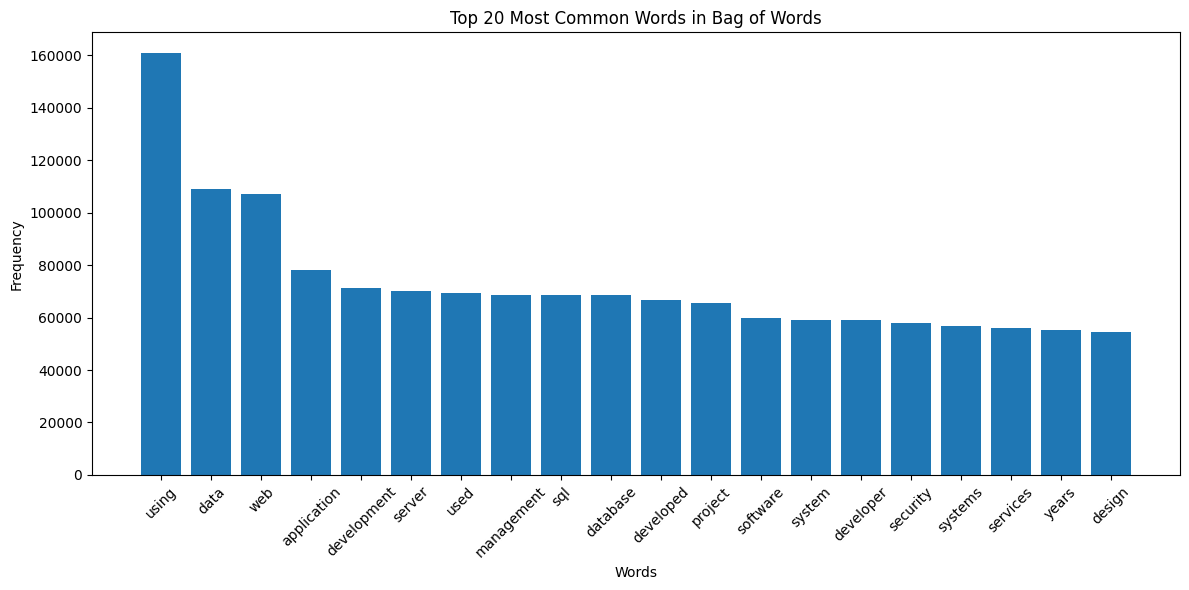

In [ ]:
# BoW Visualization
bow_feature_names = vectorizer.get_feature_names_out()
bow_feature_counts = X_train_df.sum()

# Select the top N most common words for visualization
top_n = 20
most_common_bow = bow_feature_counts.nlargest(top_n)

plt.figure(figsize=(12, 6))
plt.bar(most_common_bow.index, most_common_bow.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Common Words in Bag of Words'.format(top_n))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tf-idf

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=1000,
    sublinear_tf=True,
    smooth_idf=True,
    use_idf=True
)
X_train_vectorized = vectorizer.fit_transform(train_prep)
X_valid_vectorized = vectorizer.transform(val_prep)
X_test_vectorized = vectorizer.transform(test_prep)

In [ ]:
vectorized_df = pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
vectorized_df

,000,10,10 years,10g,11g,12c,2000,2003,2004,2005,...,wsdl,www,xhtml,xml,xp,year,years,years experience,york,york ny
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.121766,0.0,0.000000,0.000000,0.105442,0.201125,0.000000,0.000000,0.000000
1,0.0,0.038170,0.000000,0.0,0.0,0.0,0.167164,0.173499,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.054114,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.072921,0.0,0.000000,0.000000,0.063145,0.000000,0.000000,0.144364,0.091135
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.079411,0.0,0.000000,0.000000,0.000000,0.042594,0.000000,0.194861,0.099246
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.051488,0.083038,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17865,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.067171,0.0,0.000000,0.000000,0.000000,0.061002,0.000000,0.000000,0.000000
17866,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.055215,0.000000,0.000000,0.000000
17867,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.231571,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.094050,0.000000,0.048732,0.000000,0.000000,0.000000
17868,0.0,0.069734,0.099085,0.0,0.0,0.0,0.000000,0.000000,0.0,0.159847,...,0.0,0.000000,0.0,0.080812,0.000000,0.000000,0.086732,0.082615,0.000000,0.000000


### Word2Vec

In [ ]:
sentences = [resume.split() for resume in train_prep]
word2vec_model = Word2Vec(sentences, vector_size=350, window=15, min_count=3, workers=4)

In [ ]:
def get_average_word_embedding(resume, word2vec_model):
    word_embeddings = [word2vec_model[word] for word in resume.split() if word in word2vec_model]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        # If none of the words are in the Word2Vec model, return zeros
        return np.zeros(word2vec_model.vector_size)

In [ ]:
X_train_word2vec = np.vstack(train_prep.apply(lambda x: get_average_word_embedding(x, word2vec_model.wv)))
X_valid_word2vec = np.vstack(val_prep.apply(lambda x: get_average_word_embedding(x, word2vec_model.wv)))
X_test_word2vec = np.vstack(test_prep.apply(lambda x: get_average_word_embedding(x, word2vec_model.wv)))

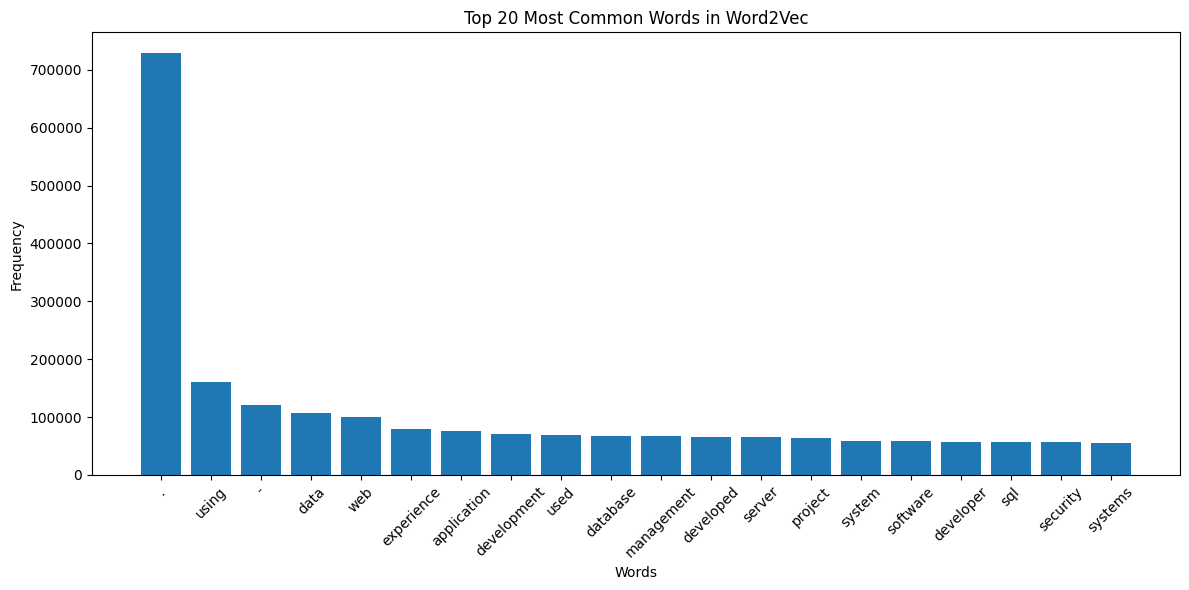

In [ ]:
# Word2Vec Visualization
all_words = [word for resume in train_prep for word in resume.split()]
word_counts = Counter(all_words)

# Select the top N most common words for visualization
most_common_w2v = word_counts.most_common(top_n)

words, counts = zip(*most_common_w2v)

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Most Common Words in Word2Vec'.format(top_n))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ROC AUC function

In [ ]:
def plot_roc_auc(y_true, y_pred, feature_type):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {feature_type}')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression

In [ ]:
logreg_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='ovr',
    class_weight='balanced'
)

In [ ]:
multi_output_logreg_model = MultiOutputClassifier(logreg_model)
# Train using BoW features
multi_output_logreg_model.fit(X_train_bow, train_labels_binarized)

y_valid_pred_lr_bow = multi_output_logreg_model.predict(X_val_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.84      0.92      0.88       652
   Front_End_Developer       0.76      0.88      0.81       782
        Java_Developer       0.82      0.91      0.86       665
 Network_Administrator       0.73      0.86      0.79       913
       Project_manager       0.72      0.88      0.79       883
      Python_Developer       0.86      0.92      0.89       572
      Security_Analyst       0.76      0.89      0.82       636
    Software_Developer       0.96      0.94      0.95      3038
 Systems_Administrator       0.79      0.87      0.83      1165
         Web_Developer       0.82      0.89      0.85      1348

             micro avg       0.83      0.90      0.87     10654
             macro avg       0.81      0.90      0.85     10654
          weighted avg       0.84      0.90      0.87     10654
           samples avg       0.85      0.90      0.85     10654



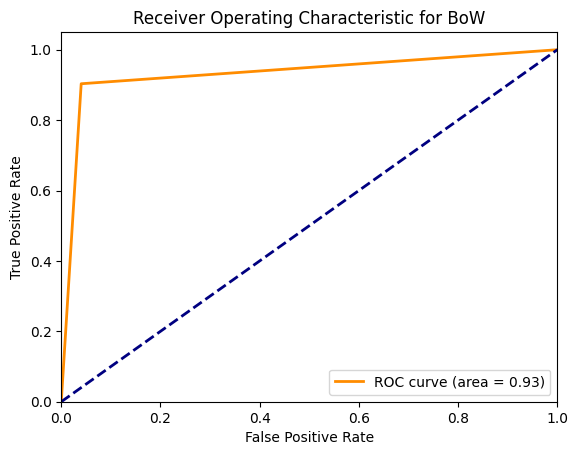

In [ ]:
results['BoW']['Logistic Regression'] = f1_score(validation_labels_binarized, y_valid_pred_lr_bow, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_lr_bow, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_lr_bow, 'BoW')

In [ ]:
multi_output_logreg_model = MultiOutputClassifier(logreg_model)
#Train using Tf-Idf features
multi_output_logreg_model.fit(X_train_vectorized, train_labels_binarized)

y_valid_pred_lr_t = multi_output_logreg_model.predict(X_valid_vectorized)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.87      0.94      0.90       652
   Front_End_Developer       0.74      0.92      0.82       782
        Java_Developer       0.76      0.94      0.84       665
 Network_Administrator       0.70      0.91      0.79       913
       Project_manager       0.73      0.91      0.81       883
      Python_Developer       0.83      0.97      0.90       572
      Security_Analyst       0.71      0.96      0.81       636
    Software_Developer       0.97      0.94      0.96      3038
 Systems_Administrator       0.77      0.87      0.82      1165
         Web_Developer       0.73      0.91      0.81      1348

             micro avg       0.80      0.93      0.86     10654
             macro avg       0.78      0.93      0.85     10654
          weighted avg       0.82      0.93      0.86     10654
           samples avg       0.83      0.92      0.85     10654



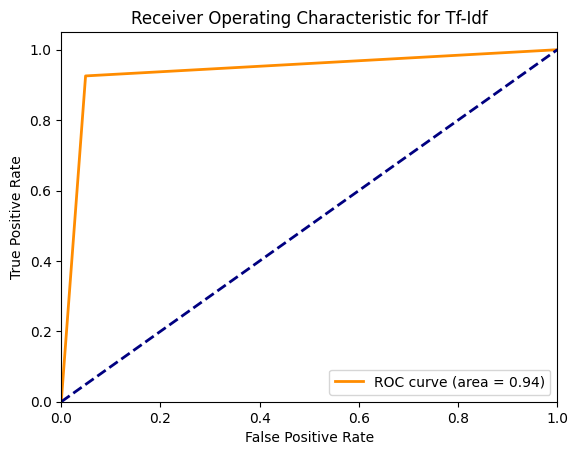

In [ ]:
results['Tf-Idf']['Logistic Regression'] = f1_score(validation_labels_binarized, y_valid_pred_lr_t, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_lr_t, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_lr_t, 'Tf-Idf')

In [ ]:
multi_output_logreg_model = MultiOutputClassifier(logreg_model)
# Train using Word2vec features
multi_output_logreg_model.fit(X_train_word2vec, train_labels_binarized)

y_valid_pred_lr_w2v = multi_output_logreg_model.predict(X_valid_word2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.71      0.89      0.79       652
   Front_End_Developer       0.68      0.91      0.78       782
        Java_Developer       0.68      0.94      0.79       665
 Network_Administrator       0.65      0.89      0.75       913
       Project_manager       0.62      0.88      0.73       883
      Python_Developer       0.75      0.94      0.84       572
      Security_Analyst       0.64      0.92      0.75       636
    Software_Developer       0.97      0.93      0.95      3038
 Systems_Administrator       0.66      0.85      0.75      1165
         Web_Developer       0.64      0.88      0.74      1348

             micro avg       0.73      0.90      0.81     10654
             macro avg       0.70      0.90      0.79     10654
          weighted avg       0.75      0.90      0.81     10654
           samples avg       0.76      0.90      0.80     10654



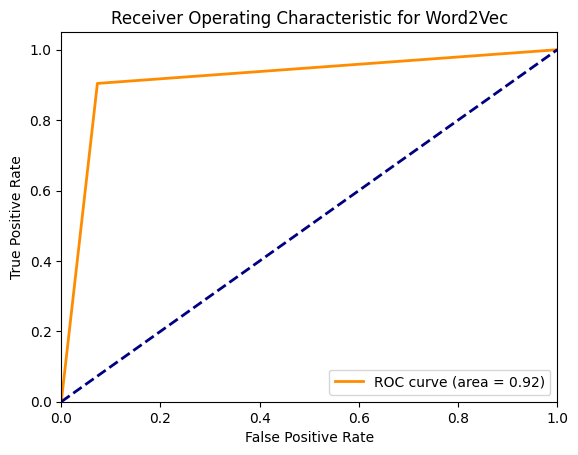

In [ ]:
results['Word2Vec']['Logistic Regression'] = f1_score(validation_labels_binarized, y_valid_pred_lr_w2v, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_lr_w2v, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_lr_w2v, 'Word2Vec')

### SVM

In [ ]:
# Create LinearSVC model
svm_model = LinearSVC(dual=False, class_weight='balanced')

In [ ]:
multi_output_svm_model = MultiOutputClassifier(svm_model)
# Train using BoW features
multi_output_svm_model.fit(X_train_bow, train_labels_binarized)

y_valid_pred_svm_bow = multi_output_svm_model.predict(X_val_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.81      0.91      0.86       652
   Front_End_Developer       0.73      0.86      0.79       782
        Java_Developer       0.82      0.90      0.86       665
 Network_Administrator       0.72      0.86      0.79       913
       Project_manager       0.71      0.89      0.79       883
      Python_Developer       0.88      0.92      0.90       572
      Security_Analyst       0.74      0.88      0.81       636
    Software_Developer       0.97      0.94      0.95      3038
 Systems_Administrator       0.79      0.86      0.82      1165
         Web_Developer       0.82      0.88      0.85      1348

             micro avg       0.83      0.90      0.86     10654
             macro avg       0.80      0.89      0.84     10654
          weighted avg       0.83      0.90      0.86     10654
           samples avg       0.84      0.90      0.85     10654



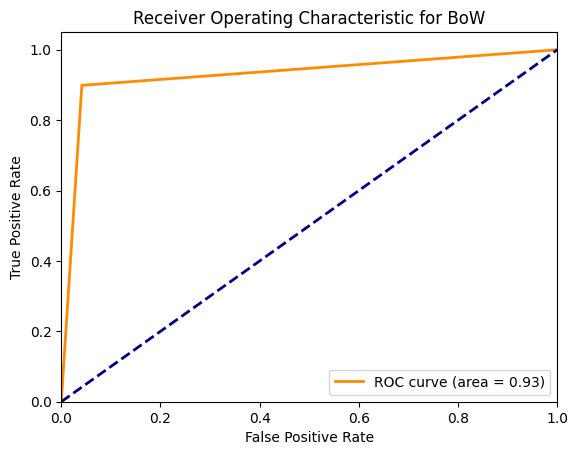

In [ ]:
results['BoW']['SVM'] = f1_score(validation_labels_binarized, y_valid_pred_svm_bow, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_svm_bow, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_svm_bow, 'BoW')

In [ ]:
multi_output_svm_model = MultiOutputClassifier(svm_model)
#Train using Tf-Idf features
multi_output_svm_model.fit(X_train_vectorized, train_labels_binarized)

y_valid_pred_svm_t = multi_output_svm_model.predict(X_valid_vectorized)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.88      0.95      0.91       652
   Front_End_Developer       0.76      0.90      0.83       782
        Java_Developer       0.80      0.94      0.86       665
 Network_Administrator       0.72      0.89      0.80       913
       Project_manager       0.74      0.90      0.81       883
      Python_Developer       0.88      0.96      0.92       572
      Security_Analyst       0.73      0.94      0.82       636
    Software_Developer       0.98      0.95      0.96      3038
 Systems_Administrator       0.80      0.87      0.84      1165
         Web_Developer       0.78      0.92      0.85      1348

             micro avg       0.83      0.92      0.87     10654
             macro avg       0.81      0.92      0.86     10654
          weighted avg       0.84      0.92      0.88     10654
           samples avg       0.85      0.92      0.86     10654



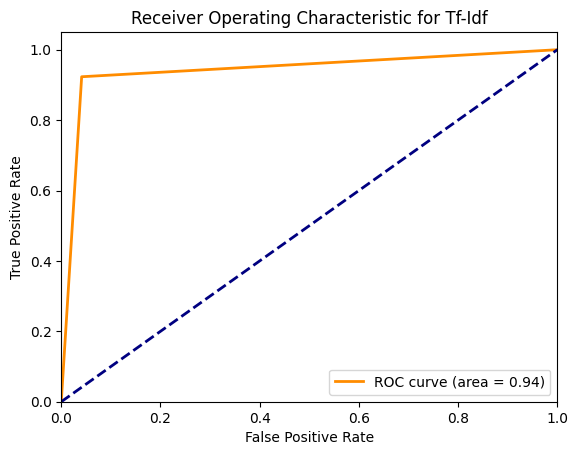

In [ ]:
results['Tf-Idf']['SVM'] = f1_score(validation_labels_binarized, y_valid_pred_svm_t, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_svm_t, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_svm_t, 'Tf-Idf')

In [ ]:
multi_output_svm_model = MultiOutputClassifier(svm_model)
# Train using Word2vec features
multi_output_svm_model.fit(X_train_word2vec, train_labels_binarized)

y_valid_pred_svm_w2v = multi_output_svm_model.predict(X_valid_word2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.70      0.89      0.79       652
   Front_End_Developer       0.69      0.90      0.78       782
        Java_Developer       0.67      0.93      0.78       665
 Network_Administrator       0.65      0.89      0.75       913
       Project_manager       0.63      0.88      0.73       883
      Python_Developer       0.75      0.94      0.83       572
      Security_Analyst       0.63      0.92      0.74       636
    Software_Developer       0.97      0.93      0.95      3038
 Systems_Administrator       0.67      0.85      0.75      1165
         Web_Developer       0.64      0.87      0.74      1348

             micro avg       0.73      0.90      0.81     10654
             macro avg       0.70      0.90      0.78     10654
          weighted avg       0.75      0.90      0.81     10654
           samples avg       0.76      0.90      0.80     10654



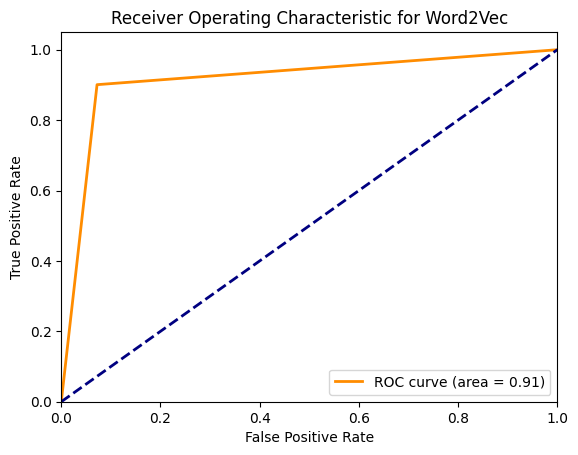

In [ ]:
results['Word2Vec']['SVM'] = f1_score(validation_labels_binarized, y_valid_pred_svm_w2v, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_svm_w2v, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_svm_w2v, 'Word2Vec')

### Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)

In [ ]:
multi_output_rf_model = MultiOutputClassifier(rf_model)

# Train using BoW features
multi_output_rf_model.fit(X_train_bow, train_labels_binarized)

feature_importances = multi_output_rf_model.estimators_[0].feature_importances_
important_feature_indices = feature_importances.argsort()[-100:]  # Select top 100 features
X_train_bow_selected = X_train_bow[:, important_feature_indices]
X_val_bow_selected = X_val_bow[:, important_feature_indices]

# Train using selected features
multi_output_rf_model.fit(X_train_bow_selected, train_labels_binarized)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42))

In [ ]:
y_valid_pred_rf_bow = multi_output_rf_model.predict(X_val_bow_selected)

# Threshold probabilities for multi-label
y_valid_pred_rf_bow = (y_valid_pred_rf_bow > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.97      0.92      0.94       652
   Front_End_Developer       0.86      0.85      0.85       782
        Java_Developer       0.89      0.85      0.87       665
 Network_Administrator       0.87      0.84      0.85       913
       Project_manager       0.89      0.79      0.84       883
      Python_Developer       0.89      0.69      0.77       572
      Security_Analyst       0.87      0.87      0.87       636
    Software_Developer       0.97      0.95      0.96      3038
 Systems_Administrator       0.88      0.78      0.83      1165
         Web_Developer       0.90      0.85      0.87      1348

             micro avg       0.91      0.86      0.89     10654
             macro avg       0.90      0.84      0.87     10654
          weighted avg       0.91      0.86      0.89     10654
           samples avg       0.91      0.87      0.87     10654



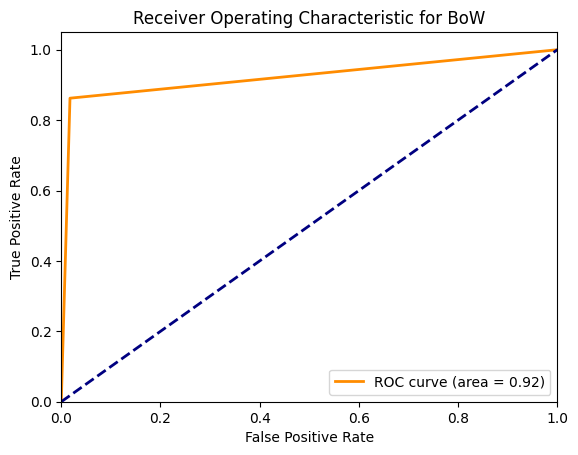

In [ ]:
results['BoW']['Random Forest'] = f1_score(validation_labels_binarized, y_valid_pred_rf_bow, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_rf_bow, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_rf_bow, 'BoW')

In [ ]:
multi_output_rf_model = MultiOutputClassifier(rf_model)
# Train using Tf-Idf features
multi_output_rf_model.fit(X_train_vectorized, train_labels_binarized)

feature_importances = multi_output_rf_model.estimators_[0].feature_importances_
important_feature_indices = feature_importances.argsort()[-100:]
X_train_tf_selected = X_train_vectorized[:, important_feature_indices]

# Train using selected features
multi_output_rf_model.fit(X_train_tf_selected, train_labels_binarized)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42))

In [ ]:
X_valid_tf_selected = X_valid_vectorized[:, important_feature_indices]
y_valid_pred_rf_t = multi_output_rf_model.predict(X_valid_tf_selected)

# Threshold probabilities for multi-label
y_valid_pred_rf_t = (y_valid_pred_rf_t > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.96      0.92      0.94       652
   Front_End_Developer       0.83      0.85      0.84       782
        Java_Developer       0.90      0.82      0.86       665
 Network_Administrator       0.87      0.82      0.85       913
       Project_manager       0.91      0.79      0.84       883
      Python_Developer       0.90      0.85      0.87       572
      Security_Analyst       0.88      0.87      0.88       636
    Software_Developer       0.97      0.95      0.96      3038
 Systems_Administrator       0.93      0.84      0.88      1165
         Web_Developer       0.74      0.80      0.77      1348

             micro avg       0.90      0.87      0.88     10654
             macro avg       0.89      0.85      0.87     10654
          weighted avg       0.90      0.87      0.88     10654
           samples avg       0.90      0.88      0.87     10654



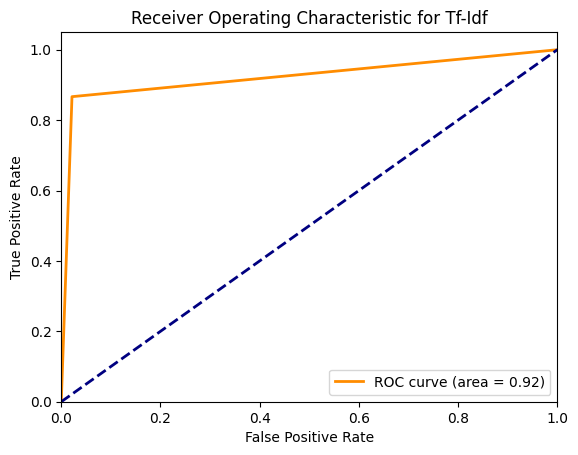

In [ ]:
results['Tf-Idf']['Random Forest'] = f1_score(validation_labels_binarized, y_valid_pred_rf_t, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_rf_t, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_rf_t, 'Tf-Idf')

In [ ]:
# Train using Word2vec features
multi_output_rf_model.fit(X_train_word2vec, train_labels_binarized)

feature_importances = multi_output_rf_model.estimators_[0].feature_importances_
important_feature_indices = feature_importances.argsort()[-350:]  # Select top 350 features
X_train_word2vec_selected = X_train_word2vec[:, important_feature_indices]
X_valid_word2vec_selected = X_valid_word2vec[:, important_feature_indices]

# Train using selected features
multi_output_rf_model.fit(X_train_word2vec_selected, train_labels_binarized)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42))

In [ ]:
y_valid_pred_rf_w2v = multi_output_rf_model.predict(X_valid_word2vec_selected)

# Threshold probabilities for multi-label
y_valid_pred_rf_w2v = (y_valid_pred_rf_w2v > 0.5).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

Database_Administrator       0.95      0.67      0.79       652
   Front_End_Developer       0.80      0.75      0.77       782
        Java_Developer       0.89      0.80      0.84       665
 Network_Administrator       0.76      0.68      0.72       913
       Project_manager       0.85      0.64      0.73       883
      Python_Developer       0.93      0.76      0.84       572
      Security_Analyst       0.88      0.70      0.78       636
    Software_Developer       0.97      0.93      0.95      3038
 Systems_Administrator       0.76      0.69      0.72      1165
         Web_Developer       0.70      0.75      0.72      1348

             micro avg       0.86      0.77      0.81     10654
             macro avg       0.85      0.74      0.79     10654
          weighted avg       0.86      0.77      0.81     10654
           samples avg       0.80      0.77      0.76     10654



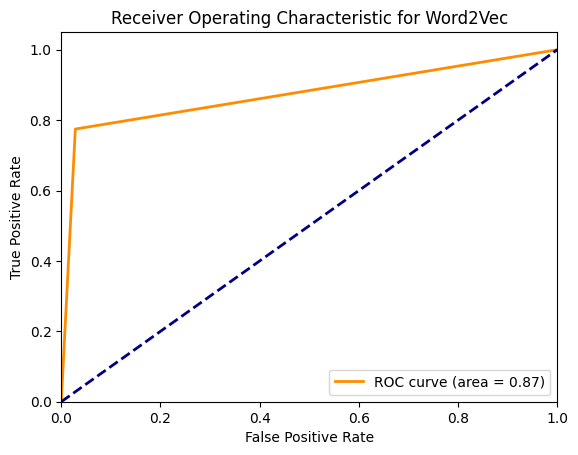

In [ ]:
results['Word2Vec']['Random Forest'] = f1_score(validation_labels_binarized, y_valid_pred_rf_w2v, average=None).mean()
report = classification_report(validation_labels_binarized, y_valid_pred_rf_w2v, target_names=multilabel_binarizer.classes_)
print(report)
plot_roc_auc(validation_labels_binarized, y_valid_pred_rf_w2v, 'Word2Vec')

In [ ]:
results

{'BoW': {'Logistic Regression': 0.8481818508346836,
  'SVM': 0.8413808311939223,
  'Random Forest': 0.8671632780249603},
 'Tf-Idf': {'Logistic Regression': 0.8458915608174721,
  'SVM': 0.8595451637974513,
  'Random Forest': 0.8692543114184096},
 'Word2Vec': {'Logistic Regression': 0.7858779922204306,
  'SVM': 0.7843065553124108,
  'Random Forest': 0.7870469183873657}}

### Result

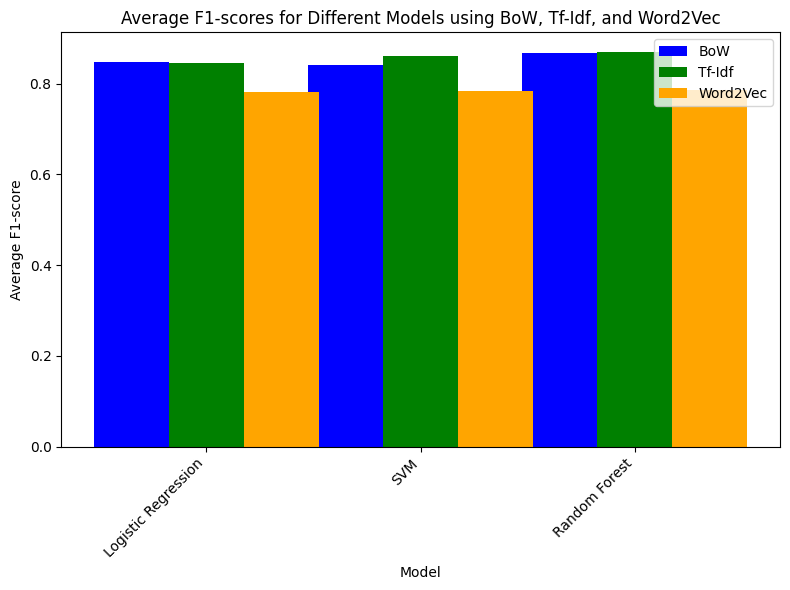

In [ ]:
# Create a bar plot to compare average F1-scores
plt.figure(figsize=(8, 6))

# Extract data for plotting
labels = list(results['BoW'].keys())  # Model names
bow_scores = [results['BoW'][model_name] for model_name in labels]
tf_scores = [results['Tf-Idf'][model_name] for model_name in labels]
w2v_scores = [results['Word2Vec'][model_name] for model_name in labels]

bar_width = 0.35
index = range(len(labels))

plt.bar(index, bow_scores, width=bar_width, label='BoW', color='blue')
plt.bar([i + bar_width for i in index], tf_scores, width=bar_width, label='Tf-Idf', color='green')
plt.bar([i + 2 * bar_width for i in index], w2v_scores, width=bar_width, label='Word2Vec', color='orange')

plt.xlabel('Model')
plt.ylabel('Average F1-score')
plt.title('Average F1-scores for Different Models using BoW, Tf-Idf, and Word2Vec')
plt.xticks([i + bar_width for i in index], labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()